In [1]:
# encoding: UTF-8
# Copyright Diogenes Ademir Domingos 2017
# Authored by Diogenes Ademir Domingos (k.fus@hotamil.com)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [185]:
# Configunrando o notebook.

import itertools
import random
import numpy as np
import matplotlib.pyplot as plt

# Configunrando o framework Keras.

# Importando a base de dados MNIST (http://yann.lecun.com/exdb/mnist/)
from keras.datasets import mnist

# Importando o modelo do Keras (https://keras.io/getting-started/sequential-model-guide/)
from keras.models import Sequential

# Importando o tipo de camada
from keras.layers import Dense

# Importando modulo de Dropout da rede, para aplicar mutações.
from keras.layers import Dropout

# Importando modulo de achatamento dos vetores.
# Aprimora a entrada. Não afeta o tamanho do lote.
# (https://keras.io/layers/core/#flatten)
from keras.layers import Flatten

# Importanto modulo de convolução (https://keras.io/layers/convolutional/)
from keras.layers.convolutional import Conv2D

# Importando modulo de subamostragem (https://keras.io/layers/pooling/)
from keras.layers.convolutional import MaxPooling2D

# Importando Lib de utilidades (https://keras.io/utils/)
from keras.utils import np_utils

# Importante modulo de trabalho em backend (Th ou Tf) (https://keras.io/backend/)
from keras import backend as K

# modulo para trabalhar reprocessar as imagens
from keras.preprocessing import image

# modulo de utilizades para trabalhar reprocessar as imagens
from keras.utils.data_utils import get_file

#import keras_mnist_vis 
#K.set_image_dim_ordering('th')

# permitindo mais de um print por saída
from __future__ import print_function

# Configurando o plot para ser inline ao inves de outra janela.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
# Load dos dados
# Criando uma matriz numpy de dados de treino.
# Criando uma matriz numpy de dados de teste.
# O conjunto de treinamento possui 60.000 exemplos
# O conjunto de testes de 10.000 exemplos

(X_train, y_train), (X_test, y_test) = mnist.load_data()
print('Dados de treino shape: ', X_train.shape)
print('Rotulos de treino shape: ', y_train.shape)
print('Dados de teste shape: ', X_test.shape)
print('Rotulos de teste: ', y_test.shape)

Dados de treino shape:  (60000, 28, 28)
Rotulos de treino shape:  (60000,)
Dados de teste shape:  (10000, 28, 28)
Rotulos de teste:  (10000,)


In [77]:
# backup para predição

X_test_orig = X_test
print('Dados de teste backup: ', X_test_orig.shape)

Dados de teste backup:  (10000, 28, 28)


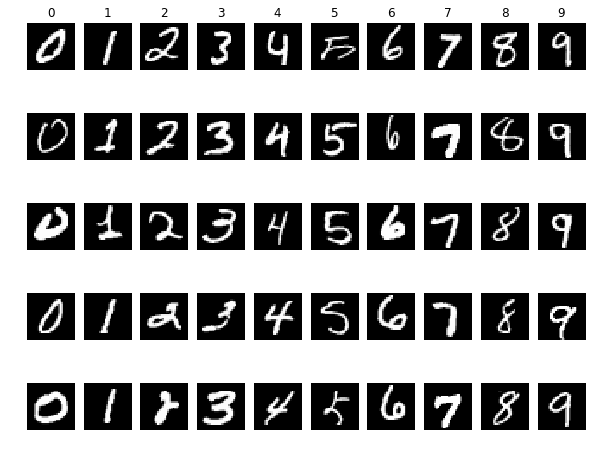

In [78]:
# Visualizando amostra dos dados
# Vetor de classes para indice
classes = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']
quantidade_classes = len(classes)
amostras_por_classe = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, amostras_por_classe, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * quantidade_classes + y + 1
        plt.subplot(amostras_por_classe, quantidade_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [79]:
# Configuração do shape da imagem
# Este shape varia de acordo com o framework de backend
# tenshoflow = (quantidade de canais, largura, altura)
# theano = (largura, altura, quantidade de canais)

img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    shape = (1, img_rows, img_cols)
else:  # channel_last
    shape = (img_rows, img_cols, 1)

print(shape)

(28, 28, 1)


In [80]:
# Alterando os canais de cor para ter apenas um canal
X_train = X_train.reshape((X_train.shape[0],) + shape).astype('float32')
X_test = X_test.reshape((X_test.shape[0],) + shape).astype('float32')

In [81]:
# Binarizando pixels
X_train = X_train / 255
X_test = X_test / 255

In [82]:
# Visualizando dimensão dos dados.
# (Quantidade, largura, altura)
print('Dados de treino shape: ', X_train.shape)
print('Rotulos de treino shape: ', y_train.shape)
print('Dados de teste shape: ', X_test.shape)
print('Rotulos de teste: ', y_test.shape)

Dados de treino shape:  (60000, 28, 28, 1)
Rotulos de treino shape:  (60000,)
Dados de teste shape:  (10000, 28, 28, 1)
Rotulos de teste:  (10000,)


Formato do dataset: (60000, 28, 28, 1)
Labels: [5 0 4 ..., 5 6 8]
Labels shape: (60000,)
Formato da imagem: (28, 28, 1)


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.000000,0.313726,0.741176,0.996078,1.000000,0.996078,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.313726,0.949020,0.992157,0.992157,0.992157,0.992157,...,0.784314,0.227451,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.396078,0.992157,0.992157,0.992157,0.992157,0.992157,...,0.992157,0.890196,0.207843,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.984314,0.992157,0.992157,0.992157,0.992157,0.992157,...,0.992157,0.992157,0.976471,0.709804,0.066667,0.000000,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.478431,0.839216,0.839216,0.619608,0.239216,0.239216,...,0.992157,0.992157,0.992157,0.992157,0.176471,0.000000,0.0,0.0,0.0,0.0


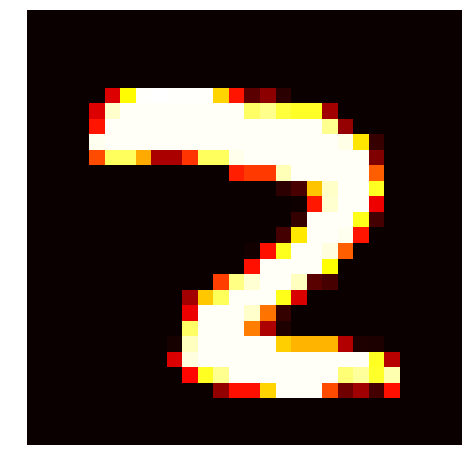

In [84]:
# Visualizar a matriz de pixels da imagem.
from IPython.display import display
import pandas as pd

print("Formato do dataset: {}".format(X_train.shape))
print("Labels: {}".format(y_train))
print("Labels shape: {}".format(y_train.shape))

# Seleciona uma imagem aleatoria
idx_img_aleatoria = random.randint(0, len(X_train[0]))
img_aleatoria = X_train[idx_img_aleatoria]
print("Formato da imagem: {}".format(img_aleatoria.shape))

# Visualizar a imagem aleatoria
plt.imshow(img_aleatoria.reshape(28,28), cmap='hot')
plt.axis('off')

# Imprime os pixels da imagem como tabela
display(pd.DataFrame(img_aleatoria.reshape(28,28)))

In [85]:
# Definindo a qunatidade de neurõnios por camada da RNA

# quantidade de pixels na camada de entrada de dados
# um neuronio para cada pixel
if K.image_data_format() == 'channels_first':
    num_pixels = X_train.shape[2] * X_train.shape[3]
else:
    num_pixels = X_train.shape[1] * X_train.shape[2]
    
print("Quantidade de neurônios (camada entrada): ",num_pixels)

Quantidade de neurônios (camada entrada):  784


In [86]:
# criando a classificação
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [87]:
# verificando a quantidade de classes encontradas
num_classes = y_test.shape[1]
print('Classes encontradas shape: ',y_test.shape)

Classes encontradas shape:  (10000, 10)


In [88]:
# Criando arquitetura da rede DNN
def deep_cnn_model(num_pixels, num_classes, shape, activation='relu'):
    
    # inicialização de hyperparamentros
	nucleos = 32
	nucleos_dim_1 = 3
	nucleos_dim_2 = 2
	nucleos_dim_2 = 2
	neuronios_camada_densa = 128
    
	model = Sequential() # tipo keras senquencial (https://keras.io/getting-started/sequential-model-guide/)
  
    # [Primeira camada]
    # Adicionando uma camada de convolução (Convolution2D - com esparsividade) para entrada de dados. 
    # Camada ConvNet terá 30 núcleos (campos receptivos de 5 x 5 pixels).
    # Arranjo espacial cmo apenas 1 canal de cor e imagem no tamanho 28x28
    # Função de ativação do neurônio será Relu (https://en.wikipedia.org/wiki/Rectifier_(neural_networks))
	model.add(Conv2D(nucleos, (nucleos_dim_1, nucleos_dim_1), padding='same', input_shape=shape, activation= activation))
    
    #[Segunda Camada]
    # Adicionando uma camada de convolução (Convolution2D - com esparsividade).
    # Camada ConvNet terá 64 núcleos (campos receptivos de 3 x 3 pixels).
    # Função de ativação do neurônio será Relu (https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) 
	model.add(Conv2D(nucleos * 2, (nucleos_dim_1, nucleos_dim_1), activation= activation))
    
    # [Terceira Camada]
    # Adicionando uma camada de subamostragem (MaxPooling2D).
    # Imagens redimensionadas para 2 × 2 pixels.
	model.add(MaxPooling2D(pool_size=(nucleos_dim_2, nucleos_dim_2)))
    
    #[Terceira Camada]
    # Adicionando uma camada de convolução (Convolution2D - com esparsividade).
    # Camada ConvNet terá 60 núcleos (campos receptivos de 3 x 3 pixels).
    # Função de ativação do neurônio será Relu (https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) 
	# model.add(Conv2D(nucleos // 2, (nucleos_dim_2, nucleos_dim_2), activation= activation))
    
    #[Quarta Camada]
    # Adicionando uma camada de subamostragem (MaxPooling2D).
    # Imagens redimensionadas para 2 × 2 pixels.
	# model.add(MaxPooling2D(pool_size=(nucleos_dim_2, nucleos_dim_2)))
    
    # O dropout atribui, aleatoriamente à entrada de uma fração unidades, valor 0
    # em cada época de treinamento. Ajuda a evitar a overfitting
    # parâmentro (0 > x < 1) é a taxa % de queda
	model.add(Dropout(0.25))
    
    # Achata o vetor
    # Aprimora a entrada. Não afeta o tamanho do lote.
	model.add(Flatten())
    
    #[Quinta Camada]
    # Adicionando camada densa (totalmente conectada) destinada a classificação.
    # Possui 128 neurônios.
    # Função de ativação do neurônio será Relu (https://en.wikipedia.org/wiki/Rectifier_(neural_networks))
	model.add(Dense(neuronios_camada_densa, activation= activation))
    
    # O dropout atribui, aleatoriamente à entrada de uma fração unidades, valor 0
    # em cada época de treinamento. Ajuda a evitar a overfitting
    # parâmentro (0 > x < 1) é a taxa % de queda
	model.add(Dropout(0.50))
    
    #[Sexta Camada]
    # Adicionando segunda camada densa (totalmente conectada) destinada a classificação.
    # Possui 64 neuronios
    # Função de ativação do neurônio será Relu (https://en.wikipedia.org/wiki/Rectifier_(neural_networks))
	#model.add(Dense(neuronios_camada_densa // 2, activation= activation))
    
    #[Sétima Camada]
    # Adicionando uma camada densa (totalmente conectada) para saída de dados, 
    # Função de ativação do neurônio será Softmax (https://en.wikipedia.org/wiki/Softmax_function)
    # tipo da camada de saída é predição
	model.add(Dense(num_classes, activation='softmax', name='preds'))
    
    # Função para otimização estocástica, requer apenas gradientes de primeira ordem com pouco requisito de memória.
    # Referência: (KINGMA, Diederik; BA, Jimmy. Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980, 2014.)
    # lr: taxa de aprendizado
    # decay: tamanho do passo da caída do gradiente
	#adam = keras.optimizers.Adam(lr=0.01, decay=1e-6)
	#adadelta = keras.optimizers.Adadelta()
        
    # Copilando o modelo
    # Função de apredizado será cross-entropy (https://en.wikipedia.org/wiki/Cross_entropy)
    # métrica de reconhecimento será precisão.
    # utilizão adam padrão, sem alterar lr.
	#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    
    # retorna o modelo compilado
	return model

In [89]:
# instanciando o modelo RNA
model = deep_cnn_model(num_pixels, num_classes, shape)

In [90]:
# Descrevendo a representação do modelo DNN
# Arranjo dimensional: 
# 1 camada de entrada;
# 2 camadas ocultas;
# 1 camada de saída (preds);
# quantidade de parâmentros da rede (pesos).
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1384576   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

In [36]:
# Verificando o arranjo espacial do modelo
for i, layer in enumerate(model.layers):
    print ("Camada", i, "\t", layer.name.strip(),"\t\t", layer.input_shape, "\t", layer.output_shape)

Camada 0 	 conv2d_1 		 (None, 28, 28, 1) 	 (None, 28, 28, 32)
Camada 1 	 conv2d_2 		 (None, 28, 28, 32) 	 (None, 26, 26, 64)
Camada 2 	 max_pooling2d_1 		 (None, 26, 26, 64) 	 (None, 13, 13, 64)
Camada 3 	 dropout_1 		 (None, 13, 13, 64) 	 (None, 13, 13, 64)
Camada 4 	 flatten_1 		 (None, 13, 13, 64) 	 (None, 10816)
Camada 5 	 dense_1 		 (None, 10816) 	 (None, 128)
Camada 6 	 dropout_2 		 (None, 128) 	 (None, 128)
Camada 7 	 preds 		 (None, 128) 	 (None, 10)


In [38]:
# Verificando o arranjo espacial do modelo com o pesos
# W.shape = matriz de pesos (quantidade de entradas, quantidade de saídas)
# b.shape = matriz de viés(bias)
for i, layer in enumerate(model.layers):
    if len(layer.get_weights()) > 0:
        W, b = layer.get_weights()
        print("Camada", i, "\t", layer.name, "\t\t", W.shape, "\t", b.shape)

Camada 0 	 conv2d_1 		 (3, 3, 1, 32) 	 (32,)
Camada 1 	 conv2d_2 		 (3, 3, 32, 64) 	 (64,)
Camada 5 	 dense_1 		 (10816, 128) 	 (128,)
Camada 7 	 preds 		 (128, 10) 	 (10,)


In [20]:
# Retorna a configuração do modelo DNN
model.get_config()

[{'class_name': 'Conv2D',
  'config': {'activation': 'relu',
   'activity_regularizer': None,
   'batch_input_shape': (None, 28, 28, 1),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'data_format': 'channels_last',
   'dilation_rate': (1, 1),
   'dtype': 'float32',
   'filters': 30,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'kernel_size': (5, 5),
   'name': 'conv2d_1',
   'padding': 'same',
   'strides': (1, 1),
   'trainable': True,
   'use_bias': True}},
 {'class_name': 'MaxPooling2D',
  'config': {'data_format': 'channels_last',
   'name': 'max_pooling2d_1',
   'padding': 'valid',
   'pool_size': (2, 2),
   'strides': (2, 2),
   'trainable': True}},
 {'class_name': 'Conv2D',
  'config': {'activation': 'relu',
   'activity_re

In [20]:
# Verificando os pesos da DNN
model.get_weights()

[array([[[[  3.68233398e-02,   5.87492287e-02,  -7.75522217e-02,
             6.90500587e-02,  -6.81096911e-02,   4.18338180e-02,
             3.37526575e-02,  -2.35735476e-02,  -2.51490399e-02,
             1.58761144e-02,   7.73245096e-02,  -2.01735944e-02,
             6.11273199e-02,   8.17168057e-02,  -1.11299008e-02,
            -6.70808256e-02,  -2.29169726e-02,  -4.44718264e-02,
             4.60702926e-03,  -2.65853629e-02,   8.11934024e-02,
             3.58363837e-02,   6.05133772e-02,   1.72200948e-02,
            -3.80287170e-02,   2.53319740e-07,  -3.81483138e-02,
             5.96283525e-02,   3.98179293e-02,  -6.12220168e-02]],
 
         [[  1.99362710e-02,  -4.30491380e-02,  -1.53989270e-02,
             7.56032765e-02,  -3.69115919e-02,  -2.66769342e-02,
             2.87271589e-02,  -8.24084878e-02,  -8.07980895e-02,
             4.62232530e-03,  -1.38049126e-02,  -2.01571286e-02,
            -8.05968046e-03,  -6.75700605e-04,   1.19783953e-02,
             8.443707

In [91]:
# Treinando o modelo DNN para 01 época
# Função FIT: realiza o treinamento até uma quantidade de épocas determinada.
# parametro validation_data: Dados para avaliar a perda do gradiente ao final de cada época
# parametro batch_size: numero de amostras para atualizar a perda do gradientes
# Paramentro verbose : 0 = silent, 1 = verbose, 2 = one log line per epoch.
# %time = medindo tempo do treino
%time history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=128, verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 252s - loss: 0.3383 - acc: 0.8981 - val_loss: 0.0762 - val_acc: 0.9763
Wall time: 4min 12s


In [92]:
# Avaliando o modelo DNN
print('Metricas do Modelo: {}'.format(model.metrics_names))
metricas = model.evaluate(X_test, y_test, verbose=0)
print("Erro de: %.2f%%" % (100-metricas[1]*100))
print("Precisão de: %.2f%%" % (metricas[1]*100))

Metricas do Modelo: ['loss', 'acc']
Erro de: 2.37%
Precisão de: 97.63%


In [97]:
# Treinando o modelo RNA para 05 épocas
# %time = medindo tempo do treino
%time history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128, verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 247s - loss: 0.1123 - acc: 0.9667 - val_loss: 0.0504 - val_acc: 0.9828
Epoch 2/5
60000/60000 [==============================] - 245s - loss: 0.0827 - acc: 0.9747 - val_loss: 0.0460 - val_acc: 0.9849
Epoch 3/5
60000/60000 [==============================] - 249s - loss: 0.0703 - acc: 0.9791 - val_loss: 0.0369 - val_acc: 0.9877
Epoch 4/5
60000/60000 [==============================] - 245s - loss: 0.0607 - acc: 0.9816 - val_loss: 0.0350 - val_acc: 0.9886
Epoch 5/5
60000/60000 [==============================] - 246s - loss: 0.0542 - acc: 0.9841 - val_loss: 0.0343 - val_acc: 0.9891
Wall time: 20min 33s


In [98]:
# Avaliando o modelo DNN
print('Metricas do Modelo: {}'.format(model.metrics_names))
metricas = model.evaluate(X_test, y_test, verbose=1)
print()
print("Erro de: %.2f%%" % (100-metricas[1]*100))
print("Precisão de: %.2f%%" % (metricas[1]*100))

Metricas do Modelo: ['loss', 'acc']
 9984/10000 [============================>.] - ETA: 0s
Erro de: 1.09%
Precisão de: 98.91%


In [99]:
# Treinando o modelo DNN para 12 épocas
# %time = medindo tempo do treino
%time history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=12, batch_size=128, verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 247s - loss: 0.0511 - acc: 0.9852 - val_loss: 0.0343 - val_acc: 0.9886
Epoch 2/12
60000/60000 [==============================] - 247s - loss: 0.0474 - acc: 0.9859 - val_loss: 0.0300 - val_acc: 0.9900
Epoch 3/12
60000/60000 [==============================] - 247s - loss: 0.0429 - acc: 0.9872 - val_loss: 0.0300 - val_acc: 0.9899
Epoch 4/12
60000/60000 [==============================] - 245s - loss: 0.0413 - acc: 0.9876 - val_loss: 0.0285 - val_acc: 0.9905
Epoch 5/12
60000/60000 [==============================] - 246s - loss: 0.0384 - acc: 0.9885 - val_loss: 0.0274 - val_acc: 0.9910
Epoch 6/12
60000/60000 [==============================] - 245s - loss: 0.0379 - acc: 0.9886 - val_loss: 0.0278 - val_acc: 0.9910
Epoch 7/12
60000/60000 [==============================] - 246s - loss: 0.0343 - acc: 0.9896 - val_loss: 0.0281 - val_acc: 0.9903
Epoch 8/12
60000/60000 [=======================

In [100]:
# Avaliando o modelo RNA
print('Metricas do Modelo: {}'.format(model.metrics_names))
metricas = model.evaluate(X_test, y_test, verbose=1)
print()
print("Erro de: %.2f%%" % (100-metricas[1]*100))
print("Precisão de: %.2f%%" % (metricas[1]*100))

Metricas do Modelo: ['loss', 'acc']
 9984/10000 [============================>.] - ETA: 0s
Erro de: 0.87%
Precisão de: 99.13%


In [101]:
# Historico do treino
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


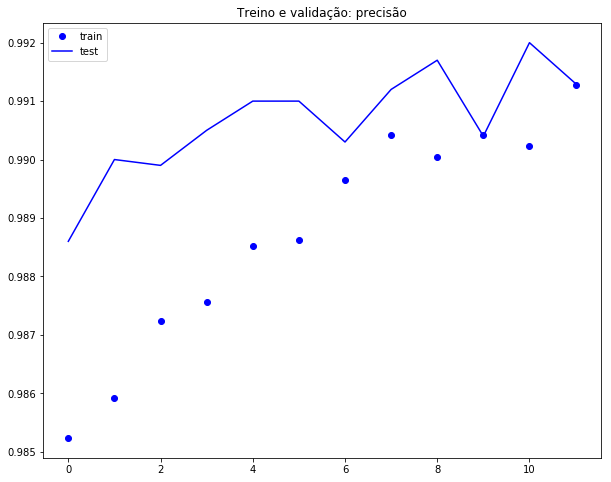

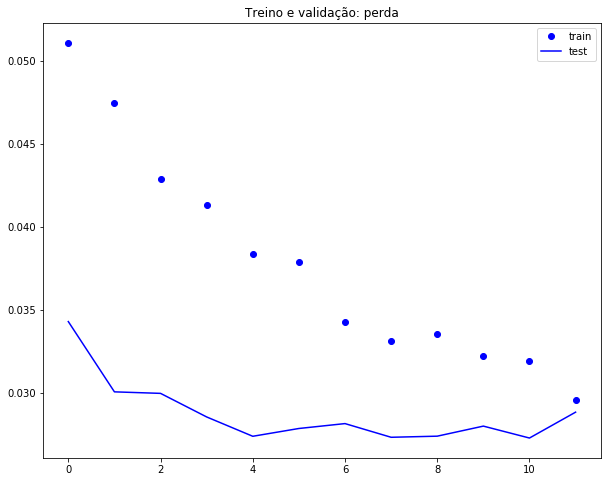

In [102]:
# Historio de precição
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'b')
plt.legend(['train', 'test'], loc='upper left')
plt.title('Treino e validação: precisão')

plt.figure()

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.legend(['train', 'test'], loc='upper right')
plt.title('Treino e validação: perda')

plt.show()

In [103]:
# utilizando o modelo para predição.
predicted = model.predict(X_test,batch_size=32, verbose=1).argmax(-1)
print('\nQuantidade de imagens analisadas: ', predicted.shape)

10000/10000 [==============================] - 12s    

Quantidade de imagens analisadas:  (10000,)


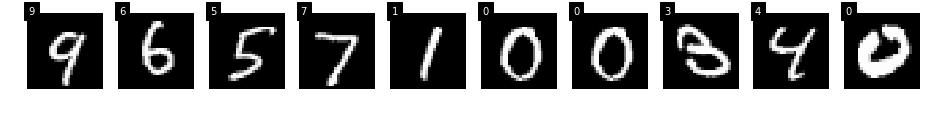

In [133]:
# Visualizando e comparando a predição com a base original.
amosta = 10
plt.figure(figsize=(16,8))
for i in range(amosta):
    plt.subplot(1, amosta, i+1)
    # Seleciona uma imagem aleatoria
    idx_img_aleatoria = random.randint(0, len(X_train[0]))
    img_aleatoria = X_test[idx_img_aleatoria]
    
    # Visualiza a imagem escolhida aleatoriamente
    plt.imshow(img_aleatoria.reshape(28,28), interpolation='nearest')
    
    # Visualiza o label
    plt.text(0, 0, predicted[idx_img_aleatoria], color='white', 
             bbox=dict(facecolor='black', alpha=1))
    plt.axis('off')

In [176]:
# Função para matriz de confusão da predição
# Referência: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Base de teste')
    plt.xlabel('Predições')

Verificando formato dos dados da predição: (10000,)
Verificando formato dos dados de testes: (10000, 10)


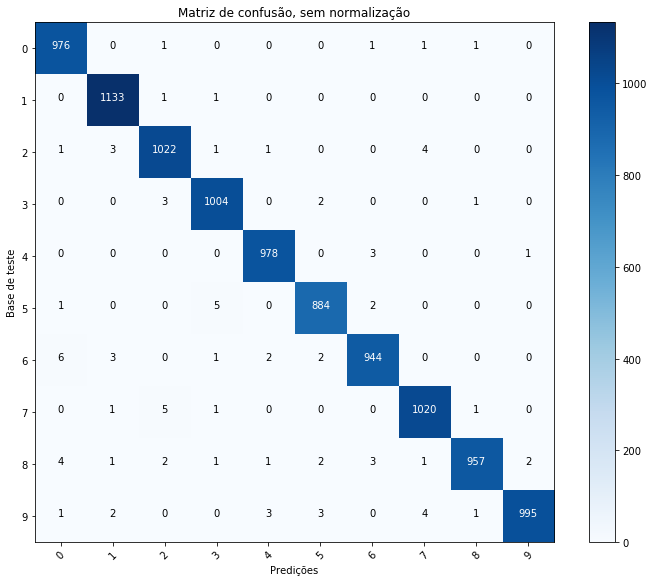

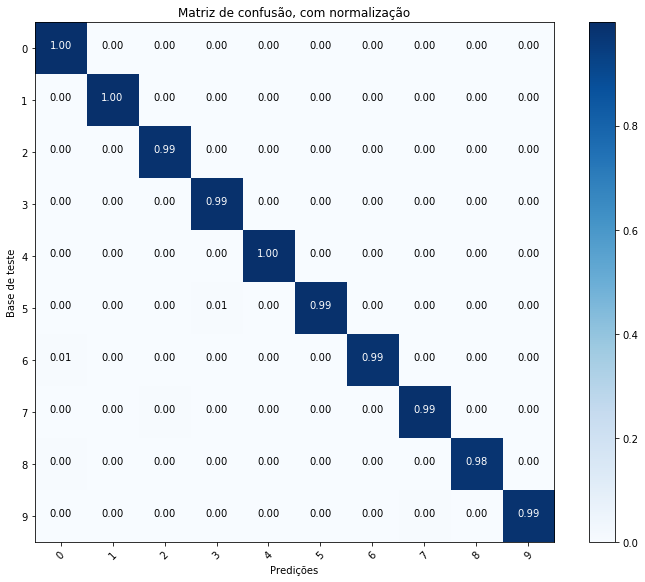

In [181]:
# Visualizando matriz de confusão da predição
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

# Precisão ter o mesmo formato
print('Verificando formato dos dados da predição: {}'.format(predicted.shape))
print('Verificando formato dos dados de testes: {}'.format(y_test.shape))

#print(confusion_matrix(np.argmax(y_test,axis=1), predicted))

cnf_matrix = confusion_matrix(np.argmax(y_test,axis=1), predicted)
np.set_printoptions(precision=2)

# Visualizando a matriz de confusão sem normalização.
# mosta a quantidade de imagens classificadas para cada label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Matriz de confusão, sem normalização')

# Visualizando a matriz de confusão com normalização.
# mosta a precisão para cada label classificado
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Matriz de confusão, com normalização')

plt.show()

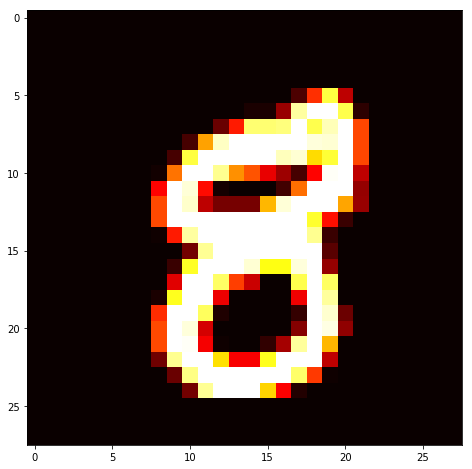

In [222]:
# Visualizando o mapa de calor

# Seleciona uma imagem aleatoria
idx_img_aleatoria = random.randint(0, X_test.shape[0])
img_aleatoria = X_test_orig[idx_img_aleatoria]

input_img_data = X_test[idx_img_aleatoria].reshape(28,28)
plt.imshow(input_img_data, cmap="hot")

In [223]:
input_img_data = np.expand_dims(input_img_data, axis=0)
print('Input image shape:', input_img_data.shape)

Input image shape: (1, 28, 28)


In [56]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1384576   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [57]:
# Listando as camadas da rede
from collections import OrderedDict
layer_dict = OrderedDict()
for layer in model.layers[0:]:
    layer_dict[layer.name] = layer
    print(layer.name)

conv2d_1
conv2d_2
max_pooling2d_1
dropout_1
flatten_1
dense_1
dropout_2
preds


In [58]:
# Buscando as ativações da camada de convolucao

def get_activations(model, layer, input_img_data):
    activations_f = K.function([model.layers[0].input, K.learning_phase()], [layer.output,])
    activations = activations_f((input_img_data, False))
    return activations

In [59]:
# Verificando o shape

img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    shape = (1, img_rows, img_cols)
else:  # channel_last
    shape = (img_rows, img_cols, 1)

print(shape)
print(input_img_data.shape)
input_img_data = input_img_data.reshape((input_img_data.shape[0],) + shape).astype('float32')
print(input_img_data.shape)

(28, 28, 1)
(1, 28, 28)
(1, 28, 28, 1)


In [60]:
# Pegando as ativações
layer_name = 'conv2d_1'
layer = layer_dict[layer_name]
activations = get_activations(model, layer, input_img_data)

In [61]:
# Visualizando o shape da primeira ativação
print(len(activations))
activation = activations[0]
activation.shape

1


(1, 28, 28, 32)

In [62]:
# Quantidade de núcleos
print('Quantidade de finltros na camada: ',layer.filters)

Quantidade de finltros na camada:  32


Quantidade de ativações na imagem:  28


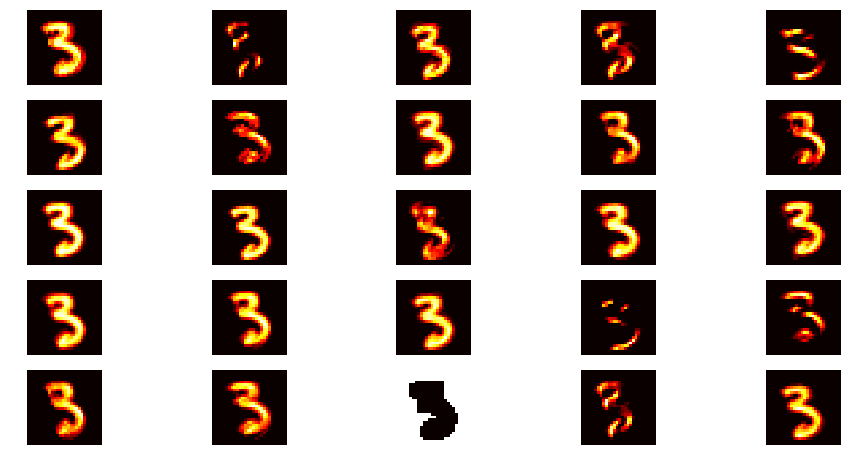

In [64]:
# Visualizando imagem através das camadas

activated_img = activation[0]
print("Quantidade de ativações na imagem: ",len(activated_img))
ativacoes_amostra = 5
fig = plt.figure(figsize=(16, 8))
for i in range(ativacoes_amostra):
    for j in range(ativacoes_amostra):
        idx = (ativacoes_amostra*i)+j
        ax = fig.add_subplot(ativacoes_amostra, ativacoes_amostra, idx+1)
        ax.imshow(activated_img[:,:,idx], cmap="hot")
        plt.axis('off')

In [65]:
# Verificando a imagem convoluida pela média
conv_img_mean = np.mean(activated_img, axis=2)

In [66]:
# confere o tamnaho do shape
conv_img_mean.shape

(28, 28)

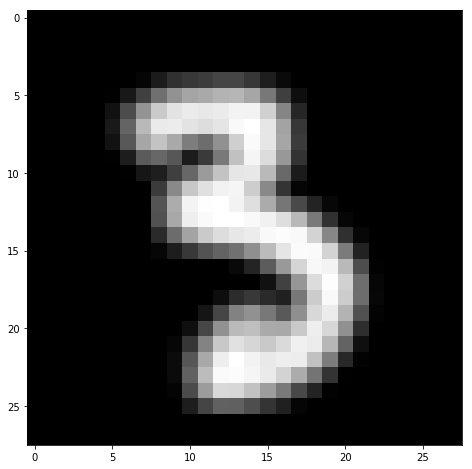

In [67]:
# Mostrar a imagem pela média
plt.imshow(conv_img_mean)

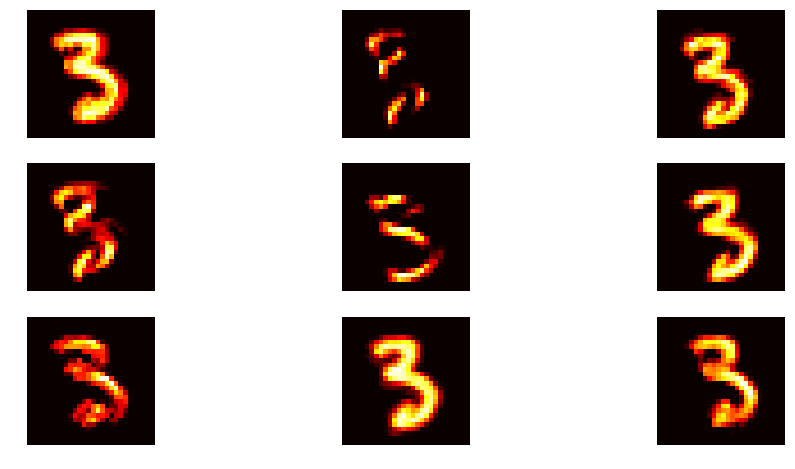

In [68]:
# Visualizando os nucleos da camanda de convolução

layer_name = 'conv2d_1'
layer = layer_dict[layer_name]
activations = get_activations(model, layer, input_img_data)

activated_img = activations[0][0] 
n = 3
fig = plt.figure(figsize=(16, 8))
for i in range(n):
    for j in range(n):
        idx = (n*i)+j
        ax = fig.add_subplot(n, n, idx+1)
        ax.imshow(activated_img[:,:,idx], cmap="hot")
        plt.axis('off')

In [69]:
# escolhendo um filtro para visualizar o nucleo
filter_index = 1

In [70]:
#layer_output = layer_dict[layer_name].output
#loss = K.mean(layer_output[:, :, :, filter_index])

In [71]:
# compute the gradient of the input picture wrt this loss
#grads = K.gradients(loss, input_img_data)[0]

In [72]:
from scipy.misc import imsave

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [73]:
# we start from a gray image with some noise
input_img_data = np.random.random((1, 3, 28, 28)) * 20 + 128.

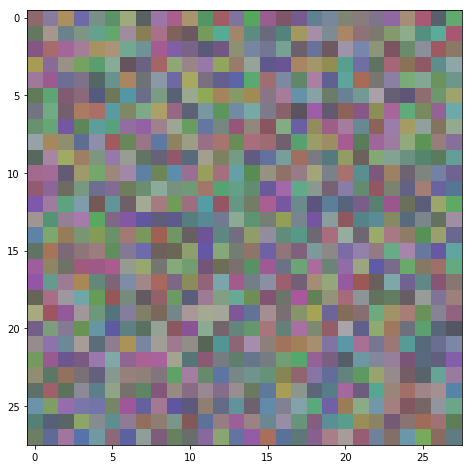

In [75]:

img = input_img_data[0]
img = deprocess_image(img)
# Mostrar a imagem pela média
plt.imshow(img)
#imsave('%s_filter_%d.png' % (layer_name, filter_index), img)